In [1]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from modeler_strats.universal_modeler import UniversalModeler
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b
import math
from statistics import variance

In [2]:
start_date = datetime(2023,4,1)
end_date = datetime.now()

In [3]:
market = Market()
speculation_db = ADatabase("spec")
classification_db = ADatabase("spec_classification")
current_db = ADatabase("current")
umod = UniversalModeler()

In [4]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [5]:
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
bench["day"] = [x.weekday() for x in bench["date"]]
bench_returns = bench
bench_returns[f"bench_return"] = (bench_returns["adjclose"].shift(-4) - bench_returns["adjclose"].shift(-1)) / bench_returns["adjclose"].shift(-1)
bench_returns["bench_return"] = bench_returns["bench_return"].fillna(0)
bench_returns["variance"] = bench_returns["bench_return"].rolling(window=100).var()
bench_returns

,date,open,high,low,close,adjclose,volume,year,quarter,week,day,bench_return,variance
0,2018-05-01,263.869995,265.100006,262.109985,264.980011,243.332672,74203400,2018,2,18,1,0.014134,NaN
1,2018-05-02,264.760010,265.679993,262.760010,263.200012,241.698044,86368900,2018,2,18,2,0.016374,NaN
2,2018-05-03,262.260010,263.359985,259.049988,262.619995,241.165375,136311500,2018,2,18,3,0.013082,NaN
3,2018-05-04,261.519989,266.790009,261.149994,266.019989,244.287643,91222100,2018,2,18,4,0.019107,NaN
4,2018-05-07,266.890015,268.019989,266.109985,266.920013,245.114182,55304900,2018,2,19,0,0.022216,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2023-04-24,411.989990,413.070007,410.600006,412.630005,412.630005,64332100,2023,2,17,0,0.024256,0.000295
1254,2023-04-25,410.579987,411.160004,406.019989,406.079987,406.079987,97766700,2023,2,17,1,0.000000,0.000291
1255,2023-04-26,406.720001,407.839996,403.779999,404.359985,404.359985,80447000,2023,2,17,2,0.000000,0.000279
1256,2023-04-27,407.000000,412.690002,406.739990,412.410004,412.410004,92968400,2023,2,17,3,0.000000,0.000267


In [6]:
tyields = pd.read_csv("./csv_files/FED/DGS1.csv")
tyields = p.column_date_processing(tyields)
tyields["dgs1"] = tyields["dgs1"].replace(".",0)
tyields["dgs1"] = tyields["dgs1"].astype("float")
tyields["yield"] = [1+(x/100) for x in tyields["dgs1"]]
tyields["weekly_yield"] = [math.exp(math.log(x)/52) for x in tyields["yield"]]
tyields

,date,dgs1,year,quarter,week,yield,weekly_yield
0,2018-04-27,2.24,2018,2,17,1.0224,1.000426
1,2018-04-30,2.24,2018,2,18,1.0224,1.000426
2,2018-05-01,2.26,2018,2,18,1.0226,1.000430
3,2018-05-02,2.24,2018,2,18,1.0224,1.000426
4,2018-05-03,2.24,2018,2,18,1.0224,1.000426
...,...,...,...,...,...,...,...
1300,2023-04-21,4.78,2023,2,16,1.0478,1.000898
1301,2023-04-24,4.76,2023,2,17,1.0476,1.000895
1302,2023-04-25,4.60,2023,2,17,1.0460,1.000865
1303,2023-04-26,4.64,2023,2,17,1.0464,1.000873


In [7]:
classification_factors = []
classification_factors.append("d1")
classification_factors.append("d2")
classification_factors.append("d3")
classification_factors.append("rolling14")

In [8]:
factors = [str(x) for x in range(14)]

In [9]:
included_columns=[
    "year",
    "week",
    "ticker",
    "adjclose",
    "y"
]
included_columns.extend(factors)
included_columns.extend(classification_factors)

In [10]:
trades = []
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 10
training_year = 4
for value in values:
    for classification in classifications:
        for ceiling in ceilings:
            for floor in floors:
                for hedge in hedges:
                    for signal in signals:
                        for req in reqs:
                            parameter = {"value":value
                                         ,"classification":classification
                                         ,"ceiling":ceiling
                                         ,"floor":floor
                                         ,"hedge":hedge
                                         ,"signal":signal
                                         ,"req":req
                                         ,"training_years":training_year}
                            parameters.append(parameter)

In [11]:
training_sets = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        prices = market.retrieve_ticker_prices("prices",ticker)
        prices = p.column_date_processing(prices)
        prices["year"] = [x.year for x in prices["date"]]
        prices["quarter"] = [x.quarter for x in prices["date"]]
        ticker_data = prices[prices["ticker"]==ticker]
        ticker_data.sort_values("date",ascending=True,inplace=True)
        ticker_data["adjclose"] = [float(x) for x in ticker_data["adjclose"]]
        ticker_data = ticker_data.groupby(["year","week"]).mean().reset_index()
        for i in range(14):
            ticker_data[str(i)] = ticker_data["adjclose"].shift(i)
        ticker_data["d1"] = ticker_data["adjclose"].pct_change(periods=1)
        ticker_data["d2"] = ticker_data["d1"].pct_change(periods=1)
        ticker_data["d3"] = ticker_data["d2"].pct_change(periods=1)
        ticker_data["rolling14"] = ticker_data["adjclose"].rolling(window=14).mean()
        ticker_data.dropna(inplace=True)
        ticker_data["ticker"] = ticker
        ticker_data["y"] = ticker_data["adjclose"].shift(-1)
        ticker_data = ticker_data.replace([np.inf, -np.inf], np.nan).dropna()
        ticker_data.dropna(inplace=True)
        ticker_data = ticker_data[included_columns]
        training_sets.append(ticker_data)
    except:
        continue
data = pd.concat(training_sets)
data = data.dropna()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:52<00:00,  9.32it/s]


In [12]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [13]:
prediction_slice = data[data["year"]==start_date.year].reset_index(drop=True)

In [14]:
speculation_db.connect()
models = speculation_db.retrieve("models")
speculation_db.disconnect()

In [15]:
classification_db.connect()
classification_models = classification_db.retrieve("models")
classification_db.disconnect()

In [16]:
simulation = umod.recommend(models,prediction_slice.copy(),factors)
simulation["week"] = simulation["week"] + 1
simulation["prediction"] = (simulation["cat_prediction"] + simulation["xgb_prediction"] + simulation["tf_prediction"]) / 3

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-03 11:17:12         2522
metadata.json                                  2023-03-03 11:17:12           64
variables.h5                                   2023-03-03 11:17:12        84160
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_absolute_percentage_error
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
260/260 [==============================] - 0s 618us/step


In [17]:
simulation

,year,week,ticker,adjclose,y,0,1,2,3,4,...,d2,d3,rolling14,xgb_prediction,xgb_score,cat_prediction,cat_score,tf_prediction,tf_score,prediction
0,2023,2,MMM,122.681938,126.880705,122.681938,118.167401,120.018608,123.209868,123.805885,...,-3.476904,7.595792,119.935581,123.393387,0.99911,123.298255,0.937924,123.487595,0.996624,123.393079
1,2023,3,MMM,126.880705,120.493744,126.880705,122.681938,118.167401,120.018608,123.209868,...,-0.104170,-0.970039,121.158728,127.931686,0.99911,126.306590,0.937924,127.037865,0.996624,127.092047
2,2023,4,MMM,120.493744,114.338678,120.493744,126.880705,122.681938,118.167401,120.018608,...,-2.470813,22.719010,122.044239,121.359016,0.99911,120.771690,0.937924,125.509865,0.996624,122.546857
3,2023,5,MMM,114.338678,114.723524,114.338678,120.493744,126.880705,122.681938,118.167401,...,0.014775,-1.005980,122.214356,114.323181,0.99911,115.482854,0.937924,121.736809,0.996624,117.180948
4,2023,6,MMM,114.723524,113.570960,114.723524,114.338678,120.493744,126.880705,122.681938,...,-1.065891,-73.143548,121.923588,114.323181,0.99911,114.572088,0.937924,119.875771,0.996624,116.257013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8307,2023,14,ZTS,164.446403,167.469901,164.446403,163.420608,164.111123,166.513957,167.475888,...,-2.491826,2.517457,161.959193,164.417664,0.99911,166.879509,0.937924,168.129715,0.996624,166.475629
8308,2023,15,ZTS,167.469901,171.964237,167.469901,164.446403,163.420608,164.111123,166.513957,...,1.929085,-1.774165,163.542195,167.554077,0.99911,166.879509,0.937924,169.540207,0.996624,167.991264
8309,2023,16,ZTS,171.964237,174.841118,171.964237,167.469901,164.446403,163.420608,164.111123,...,0.459632,-0.761736,165.356089,171.819336,0.99911,170.855584,0.937924,174.010620,0.996624,172.228513
8310,2023,17,ZTS,174.841118,174.408000,174.841118,171.964237,167.469901,164.446403,163.420608,...,-0.376617,-1.819388,166.749345,173.420776,0.99911,175.486834,0.937924,176.608688,0.996624,175.172100


In [18]:
classification_simulation = umod.recommend(classification_models,prediction_slice.copy(),classification_factors)
classification_simulation["week"] = classification_simulation["week"] + 1
classification_simulation["classification_prediction"] = ((classification_simulation["cat_prediction"] + \
                                                          classification_simulation["xgb_prediction"] + \
                                                          classification_simulation["tf_prediction"]) / 3) > 0.5

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-15 09:46:40         2141
metadata.json                                  2023-03-15 09:46:40           64
variables.h5                                   2023-03-15 09:46:40        23208
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
260/260 [==============================] - 0s 575us/step


In [19]:
classification_simulation["classification_prediction"] = [int(x) for x in classification_simulation["classification_prediction"]]

In [20]:
new_prices = []
market.connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        ticker_sim = market.retrieve_ticker_prices("prices",ticker)
        ticker_sim = p.column_date_processing(ticker_sim)
        ticker_sim = ticker_sim[(ticker_sim["date"]<end_date)]
        for i in range(2,5):
            ticker_sim[f"return_{i}"] = (ticker_sim["adjclose"].shift(-i) - ticker_sim["adjclose"].shift(-1)) / ticker_sim["adjclose"].shift(-1)
        ticker_sim["day"] = [x.weekday() for x in ticker_sim["date"]]
        returns = ticker_sim[ticker_sim["day"]==0]
        returns["weekly_return"] = returns["return_4"]
        new_sim = ticker_sim.merge(returns[["year","week","weekly_return"]], on=["year","week"],how="left")
        new_sim = new_sim.merge(bench_returns[["year","week","bench_return","variance"]],on=["year","week"],how="left").dropna()
        new_sim["market_cov"] = new_sim["weekly_return"].rolling(window=100).cov(new_sim["bench_return"])
        covs = new_sim["weekly_return"].rolling(window=100).cov(new_sim["bench_return"])
        completed = new_sim.copy()
        completed["beta"] = completed["market_cov"] / completed["variance"]
        completed  = completed.dropna().groupby(["date","ticker"]).mean().reset_index()
        new_prices.append(completed)
    except:
        continue
market.disconnect()
price_returns = pd.concat(new_prices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:51<00:00,  9.47it/s]


In [21]:
sim = price_returns.merge(simulation[["year","week","ticker","prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(classification_simulation[["year","week","ticker","classification_prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(tyields[["date","weekly_yield"]],on="date",how="left")


In [22]:
sim["projected_return"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
sim["delta"] = [abs(x) for x in sim["projected_return"]]
sim["delta_sign"] = [1 if x >= 0 else -1 for x in sim["projected_return"]]
sim["market_return"] = math.exp(np.log(1.15)/52)
sim["rrr"] = sim["weekly_yield"] + sim["beta"] * (sim["market_return"] - sim["weekly_yield"]) - 1

In [23]:
sim.columns

Index(['date', 'ticker', 'close', 'high', 'low', 'open', 'volume', 'adjclose',
       'adjhigh', 'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor',
       'year', 'quarter', 'week', 'return_2', 'return_3', 'return_4', 'day',
       'weekly_return', 'bench_return', 'variance', 'market_cov', 'beta',
       'prediction', 'classification_prediction', 'weekly_yield',
       'projected_return', 'delta', 'delta_sign', 'market_return', 'rrr'],
      dtype='object')

In [24]:
current_db.connect()
current_db.drop("trades")
for parameter in tqdm(parameters):
    b.experimental_backtest(sim.copy(),parameter,start_date,end_date,current_db)
current_db.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.92it/s]


In [25]:
current_db.connect()
t = current_db.retrieve("trades")
current_db.disconnect()

In [26]:
t = t.fillna(1)

In [27]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"])
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
        counted_columns = [x for x in range(positions)]
        cumulative = portfolio[[i for i in counted_columns]].cumprod()
        cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
        cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
        cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
        cumulative = cumulative.merge(bench_returns[["date","adjclose","bench_return","variance"]],on="date",how="left")
        cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
        cumulative["return"] = cumulative["pv"].pct_change().fillna(1)
        cumulative["beta"] = cumulative[["return","bench_return"]].cov().iloc[0][1]/cumulative["variance"].iloc[-1]
        cumulative["rrr"] = tyields["yield"].iloc[-1] + cumulative["beta"].iloc[-1]*(cumulative["bench"].iloc[-1]-tyields["yield"].iloc[-1])
        cumulative["sharpe"] = (cumulative["pv"] - tyields["yield"].iloc[-1]) / cumulative["beta"].iloc[-1]
        for index_stuff in indexer:
            cumulative[index_stuff] = parameter[index_stuff]
        analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [28]:
a.sort_values("pv",ascending=False)

,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
3,True,False,True,True,False,0.05,0.05,4,1.056850,-5.512027,1.288741,-0.001642
3,True,True,True,True,False,0.05,0.05,4,1.054024,-5.466341,1.286744,-0.001139
3,True,True,False,True,False,0.05,0.05,4,1.051960,-5.564988,1.291056,-0.000748
3,True,False,False,True,False,0.05,0.05,4,1.030984,-5.709693,1.297382,0.002945
3,True,False,True,False,False,0.05,0.05,4,0.992149,-6.692194,1.340329,0.008316
3,True,True,True,False,False,0.05,0.05,4,0.989240,-6.652751,1.338605,0.008802
3,True,True,False,False,False,0.05,0.05,4,0.984076,-6.682825,1.339919,0.009535
3,True,False,False,False,False,0.05,0.05,4,0.955028,-7.001175,1.353835,0.013251


In [29]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t.copy()
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")

In [30]:
ledger.sort_values("week").tail(20)

,year,week,ticker,delta,actual_returns,position,GICS Sector
22,2023.0,16.0,AZO,0.065472,0.999911,5,Consumer Discretionary
26,2023.0,16.0,JPM,0.060598,1.006082,6,Financials
34,2023.0,16.0,MTB,0.057376,1.013044,8,Financials
18,2023.0,16.0,CMG,0.075530,0.987888,4,Consumer Discretionary
14,2023.0,16.0,BKNG,0.088448,0.996533,3,Consumer Discretionary
10,2023.0,16.0,STT,0.091443,0.983044,2,Financials
6,2023.0,16.0,MRNA,0.111288,0.987520,1,Health Care
2,2023.0,16.0,NVR,0.132817,0.983814,0,Consumer Discretionary
38,2023.0,16.0,BAC,0.056254,1.022579,9,Financials
30,2023.0,16.0,TECH,0.058912,1.010198,7,Health Care


In [31]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
counted_columns = [x for x in range(ledger["position"].max()+1)]
for col in range(positions):
    if col not in counted_columns:
        portfolio[col] = 1
portfolio.reset_index()

position,index,year,week,0,1,2,3,4,5,6,7,8,9
0,0,2023.0,14.0,1.020939,1.008493,1.003293,1.024948,0.994157,1.080482,1.015862,0.955540,1.011414,1.004437
1,1,2023.0,15.0,1.032492,0.990222,1.030779,1.056818,1.014787,1.010009,1.007509,0.979501,1.077026,1.292176
2,2,2023.0,16.0,0.983814,0.987520,0.983044,0.996533,0.987888,0.999911,1.006082,1.010198,1.013044,1.022579
3,3,2023.0,17.0,0.950000,0.985179,1.042275,1.065340,0.950000,0.994388,0.985952,1.023766,0.988185,0.976927


In [32]:
counted_columns

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [33]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,1.020939,1.008493,1.003293,1.024948,0.994157,1.080482,1.015862,0.955540,1.011414,1.004437,2023-W14,2023-04-03,1.011956,410.950012,1.000000
1,1.054111,0.998632,1.034173,1.083183,1.008857,1.091297,1.023490,0.935953,1.089320,1.297909,2023-W15,2023-04-10,1.061693,409.609985,0.996739
2,1.037050,0.986170,1.016638,1.079428,0.996638,1.091199,1.029715,0.945497,1.103529,1.327214,2023-W16,2023-04-17,1.061308,413.940002,1.007276
3,0.985197,0.971554,1.059615,1.149958,0.946806,1.085075,1.015249,0.967968,1.090491,1.296591,2023-W17,2023-04-24,1.056850,412.630005,1.004088


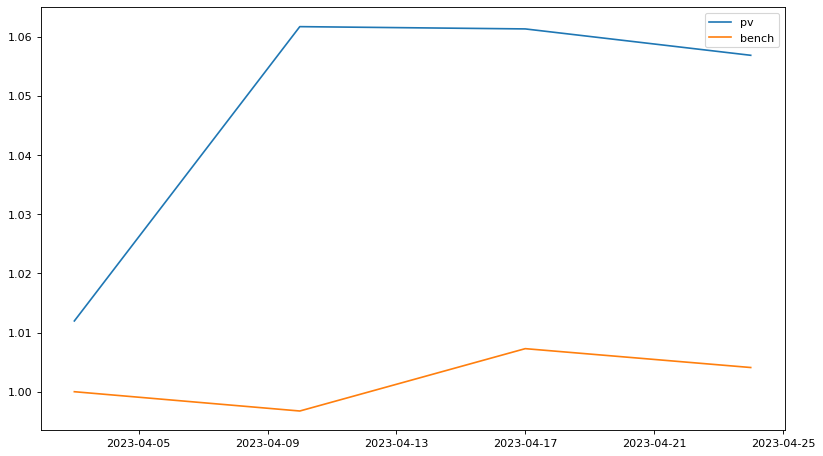

In [34]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [35]:
sim[sim["date"]==sim["date"].max()].sort_values("delta",ascending=False).head(20)[["date","ticker","delta"]]

,date,ticker,delta
295264,2023-04-28,LUMN,1.408687
174055,2023-04-28,ENPH,0.359664
152208,2023-04-28,DISH,0.240599
107139,2023-04-28,CMG,0.191994
509072,2023-04-28,ZION,0.168172
352737,2023-04-28,NVR,0.147159
332863,2023-04-28,MSCI,0.131402
210550,2023-04-28,FCX,0.121940
90755,2023-04-28,CCL,0.120438
7248,2023-04-28,ATVI,0.117809


In [36]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x not in  ["year","week"]]].cumprod()

GICS Sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Utilities
0,1.000000,1.017560,0.994157,1.006381,1.000000,1.018011,1.000000,1.000000,1.000000,1.000000
1,1.037782,1.035705,0.994157,1.006381,1.000000,1.315449,1.000000,1.014787,1.010009,1.007509
2,1.037782,1.027457,0.994157,1.006381,1.006187,1.313948,1.000000,1.014787,1.010009,1.007509
3,1.037782,1.003439,0.994157,1.006381,1.026658,1.295490,0.988185,1.014787,1.010009,1.007509
